# Machine Learning with Spark (Assignment 3)

#### Student no : 21627265
#### Student name : Eren Gülüm


## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>

Our goal in this assignment is to build different machine learning models in the Spark environment using the data set we have.We will try to achieve different and successful models using breast cancer related dataset with machine learning models.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext

## Data Understanding<a class="anchor" id="data_understanding"></a>
In this section, we will try to understand the dataset we have. For this, we will perform different operations on the dataset.
We will store the data set in the Spark DataFrame

In [0]:
data = spark.read.csv("data.csv", header=True, inferSchema=True)

In [6]:
print("Data Sample: ")
print(data.show(5))
print("Size of the DataFrame:", (data.count(), len(data.columns)))


Data Sample: 
+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+----+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|_c32|
+--------+---------+----

In [7]:
print("Summary statistics of numerical columns")
print(data.describe().show())

Summary statistics of numerical columns
+-------+--------------------+---------+------------------+-----------------+-----------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+----------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+----+
|summary|                  id|diagnosis|       radius_mean|     texture_mean|   perimeter_mean|        area_mean|     smoothness_mean|   compactness_mean|     concavity_mean| concave points_mean|       symmetry_mean|fractal_dimension_mean|         radius_se|        texture_se|      perimeter_se|          area_se

## Data Preparation<a class="anchor" id="data_preparation"></a>

In [8]:
data = data.drop('_c32') #This column is totally null column so we have to delete it
data = data.drop('id') # ID column isn't something useful for machine learning models
data.show(5)

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

Diagnosis column has categorical values.
Most of the machine learning models can't operate on categorical data so we have to convert them into numerical


In [0]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="diagnosis", outputCol="diagnosis_encoded")
data = indexer.fit(data).transform(data)

In [10]:
data = data.drop('diagnosis')  #Now we have diagnosis_encoded column(last column).So we don't need diagnosis column anymore
data.show(5) #M=1 B=0

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----------------+
|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|diagnosis_encoded|
+-----------+------------+--------------+---------

In this part, we will check the whole dataframe to know if is there any null value on the columns


In [11]:
from pyspark.sql.functions import col,sum
print("Number of NaN values per column: ")
data.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in data.columns)).show()
#There is no column with the null value

Number of NaN values per column: 
+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----------------+
|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|diagnosis_encoded|
+-----------+---

In [12]:
from pyspark.mllib.stat import Statistics
import pandas as pd

#Since i couldn't find built-in function for correlation matrix in Spark, i have used a code from github:  https://gist.github.com/cameres/bc24ac6711c9e537dd20be47b2a83558

def compute_correlation_matrix(df, method='pearson'):
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,columns=df.columns,index=df.columns)
    return corr_mat_df

compute_correlation_matrix(data)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_encoded
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066,0.730029
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205,0.415185
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019,0.742636
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738,0.708984
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316,0.358560
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382,0.596534
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930,0.696360
concave points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661,0.776614
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413,0.330499
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297,-0.012838


High correlation are more linearly dependent and hence have almost the same effect on the dependent variable.
So, when two features have high correlation, we can drop one of the two features(I will delete if corr>0.90)
With this way, we can avoid the overfitting

In [0]:
data = data.drop("perimeter_mean","area_mean","radius_worst", "perimeter_worst","area_worst")
data = data.drop("concave points_mean","texture_worst","perimeter_se")

In [14]:
print("Size of the updated DataFrame:", (data.count(), len(data.columns)))


Size of the updated DataFrame: (569, 23)


Now, we have a dataframe which have 22+1 columns in total. It was 33 at the beginning.
So 10 columns of the original dataset are deleted.

We will create two different dataframe to use them seperately (Original data and Scaled Data)

In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

pd_data = data.select("*").toPandas()
OD =pd_data.iloc[:,:-1]
OD = spark.createDataFrame(OD)
#This convertion is necessary for the machine learning models of Spark:
vecAssembler = VectorAssembler(inputCols=OD.columns, outputCol="features")
OD_vector = vecAssembler.transform(OD)


In [16]:
ND =pd_data.iloc[:,:-1]
ND =  spark.createDataFrame(ND)
vecAssembler_nd = VectorAssembler(inputCols=ND.columns, outputCol="nd_columns")
ND_Vector = vecAssembler_nd.transform(ND)

from pyspark.ml.feature import MinMaxScaler
#We will scale all of the columns(diagnosis is not included) and they will be stored inside the features vector
scaler = MinMaxScaler(inputCol="nd_columns", outputCol="features")
# rescale each feature to range [min, max].
ND_scaled = scaler.fit(ND_Vector).transform(ND_Vector)
ND_scaled.show(3)


+-----------+------------+---------------+----------------+--------------+-------------+----------------------+---------+----------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+--------------------+--------------------+
|radius_mean|texture_mean|smoothness_mean|compactness_mean|concavity_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|          nd_columns|            features|
+-----------+------------+---------------+----------------+--------------+-------------+----------------------+---------+----------+-------+-------------+--------------+------------+-----------------+-----------+--------------

Before the clustering, lets see the original distribution of the diagnosis values (by using different features)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


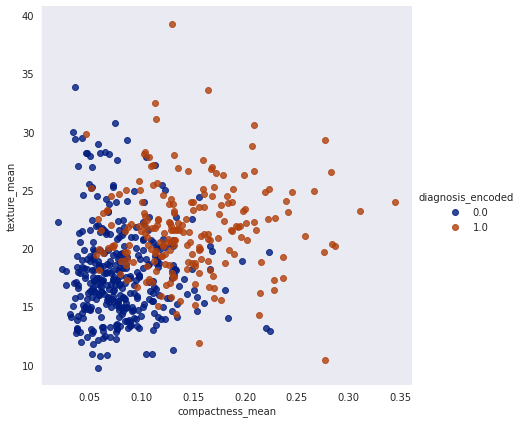

In [17]:
import seaborn as sns
#Since it is not possible to use sns visualization with spark data frame, i have used converted dataFrame(pd_data)
sns.set_style('dark')
sns.lmplot('compactness_mean','texture_mean',data=pd_data, hue='diagnosis_encoded',palette='dark',size=6,aspect=1,fit_reg=False)

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


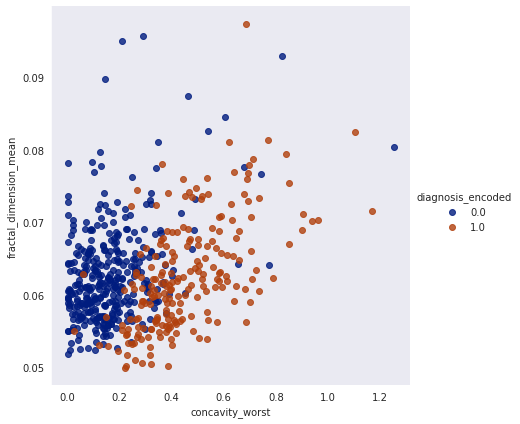

In [18]:
sns.set_style('dark')
sns.lmplot('concavity_worst','fractal_dimension_mean',data=pd_data, hue='diagnosis_encoded',palette='dark',size=6,aspect=1,fit_reg=False)

## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>


We are going to use KMeans model for the clustering. In the first part, we'll use original data. In the second, we will use scaled data and we will compare both of them.

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

#Preparing of the Kmeans model
kmeans = KMeans().setK(2).setSeed(5)
#Train the model:
model = kmeans.fit(OD_vector.select("features"))
#Predictions:
predictions = model.transform(OD_vector.select("features"))

Kmeans algorithm is an iterative algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping subgroups (K=2 in this case) where each data point belongs to only one group.

Since we have two possibilities (M and B), we can't change the k=2 value. Model also has a seed value to determine the starting centroids of the clusters. 
I have tried different Seed values(1, 5,20,50).Starting at 5, prediction success on original data decreased as the seed grew.
So seed=5 is our optimal value in this case.

In [20]:
#Evaluation of the KMeans Clustering with orginial data
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Squared euclidean distance of the Clustering(Original Data): " + str(silhouette))
# Values closer to 1 indicate maximum separation.
# Values close to zero mean the data could barely be separated. Bizimkisi 0.83 yani küme gayet iyi ayrılmış

print("Sum of Squared Errors of the Clustering(Original Data):" + str(model.computeCost(OD_vector.select("features"))))

centers_od = model.clusterCenters()

Squared euclidean distance of the Clustering(Original Data): 0.8372999674818394
Sum of Squared Errors of the Clustering(Original Data):551979.0504627795


Sum of Squared Error is too big for now
We can reduce this error measure by increasing  number of clusters.Since we have two different options(M,B), we can't change number of clusters(k)


In [21]:

#Since there is no crosstab in the Spark dataframe, we converted it to pandas dataframe and created a cross table to see the results better.
prediction_OD= predictions.select("prediction").toPandas()
crosstab = pd.crosstab(prediction_OD['prediction'], pd_data['diagnosis_encoded'])
crosstab

diagnosis_encoded,0.0,1.0
prediction,,
0,356,137
1,1,75


As can be seen, 356 + 75 = 431 points were clustered correctly, while 138 were clustered incorrectly(seed=5)



## **Clustering with Normalized Data **

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

##Preparing of the Kmeans model

kmeans = KMeans().setK(2).setSeed(5) 
#Training of the model
modelNd = kmeans.fit(ND_scaled.select("features"))
#Predictions
predictionsNd = modelNd.transform(ND_scaled.select("features"))


In [23]:
evaluatorNd = ClusteringEvaluator()
print("Squared euclidean distance of Normalized Data = " + str(evaluatorNd.evaluate(predictionsNd)))

print("Sum of Squared Errors: " + str(modelNd.computeCost(ND_scaled.select("features"))))

centersNd = modelNd.clusterCenters()

Squared euclidean distance of Normalized Data = 0.5339246587071319
Sum of Squared Errors: 154.7760611531514


SEDN= Values closer to 1 indicate maximum separation. Values close to zero mean the data could barely be separated.

Since the data was scaled, it became closer to each other. For this reason, the SEDN value, which was 0.84 in the original data, decreased to 0.53 with scaled data.


The total of the square of errors decreased for the same reason. Since scaled data is better for these models, the total of the square of errors has also decreased compared to the above model

In [24]:
pd_prediction_ND= predictionsNd.select("prediction").toPandas()
crosstab = pd.crosstab(pd_prediction_ND['prediction'], pd_data['diagnosis_encoded'])
crosstab

diagnosis_encoded,0.0,1.0
prediction,,
0,332,42
1,25,170


332 + 170 = 502 (Number Of correct predictions)

Since we use scaled data, number of false predictions(42+25) has decreased(It was 139 for the original data). It means that scaled data increased the success rate of the model

## Clustering results<a class="anchor" id="clustering"></a>

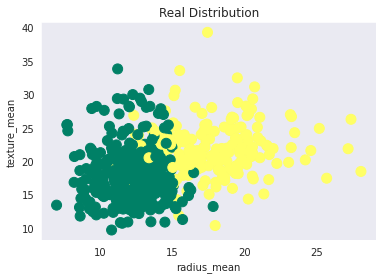

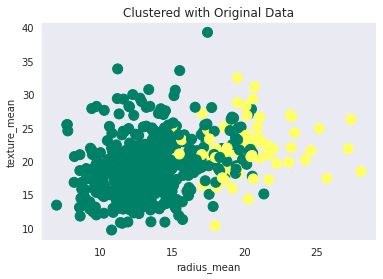

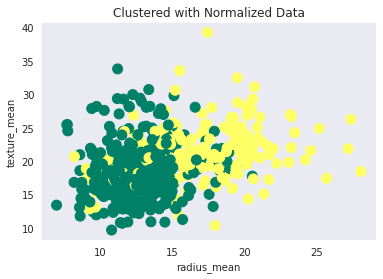

In [25]:

plt.scatter(pd_data.iloc[:, 0], pd_data.iloc[:, 1], c=pd_data.iloc[:, -1], s=100, cmap='summer')
plt.title("Real Distribution")
plt.xlabel("radius_mean")
plt.ylabel("texture_mean")
plt.show()


plt.scatter(pd_data.iloc[:, 0], pd_data.iloc[:, 1], c=prediction_OD.iloc[:,0], s=100, cmap='summer')
plt.title("Clustered with Original Data")
plt.xlabel("radius_mean")
plt.ylabel("texture_mean")
plt.show()



plt.scatter(pd_data.iloc[:, 0], pd_data.iloc[:, 1], c=pd_prediction_ND.iloc[:,0], s=100, cmap='summer')
plt.title("Clustered with Normalized Data")
plt.xlabel("radius_mean")
plt.ylabel("texture_mean")
plt.show()

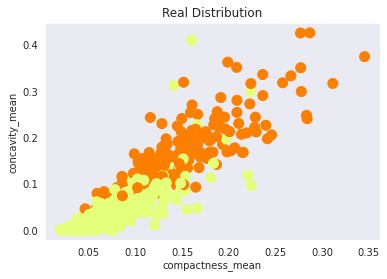

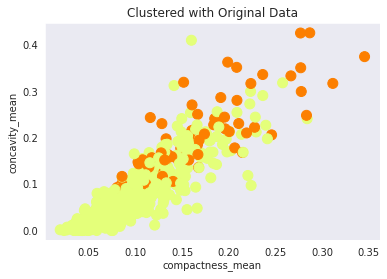

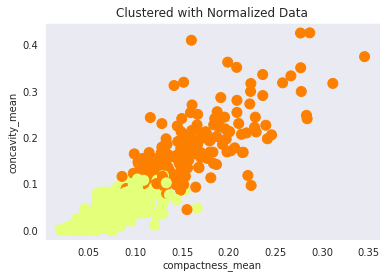

In [26]:
plt.scatter(pd_data.iloc[:, 3], pd_data.iloc[:, 4], c=pd_data.iloc[:, -1], s=100, cmap='Wistia')
plt.title("Real Distribution")
plt.xlabel("compactness_mean")
plt.ylabel("concavity_mean")
plt.show()


plt.scatter(pd_data.iloc[:, 3], pd_data.iloc[:, 4], c=prediction_OD.iloc[:,0], s=100, cmap='Wistia')
plt.title("Clustered with Original Data")
plt.xlabel("compactness_mean")
plt.ylabel("concavity_mean")
plt.show()



plt.scatter(pd_data.iloc[:, 3], pd_data.iloc[:, 4], c=pd_prediction_ND.iloc[:,0], s=100, cmap='Wistia')
plt.title("Clustered with Normalized Data")
plt.xlabel("compactness_mean")
plt.ylabel("concavity_mean")
plt.show()



## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

I am going to use Gradient Boosted Trees for the classificiation.
We will use both original and scaled data.After all, we will compare both situation
GBTs iteratively train decision trees in order to minimize a loss function (we will use 10 trees for each application)

In [0]:
#We have work with vectors.So we will create an features vector by using all columns (not diagnosis_encoded):
vecAssembler = VectorAssembler(inputCols=[i for i in data.columns if i!="diagnosis_encoded"], outputCol="features")
data_vector = vecAssembler.transform(data)

#Since we have created an features vector column, we don't need seperate feature columns.So all we need are features and diagnosis columns
droppedColumns = [str(i) for i in data_vector.columns if i not in ["diagnosis_encoded","features"]]
data_vector = data_vector.drop(*droppedColumns)

In [28]:
data_vector = data_vector.select(data_vector.features,data_vector.diagnosis_encoded)
#Our Original Dataframe is ready:
original_Data_vec = data_vector.select(data_vector.features,data_vector.diagnosis_encoded)

original_Data_vec.show(5)

+--------------------+-----------------+
|            features|diagnosis_encoded|
+--------------------+-----------------+
|[17.99,10.38,0.11...|              1.0|
|[20.57,17.77,0.08...|              1.0|
|[19.69,21.25,0.10...|              1.0|
|[11.42,20.38,0.14...|              1.0|
|[20.29,14.34,0.10...|              1.0|
+--------------------+-----------------+
only showing top 5 rows



In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#We should specify the diagnosis and features columns before the preparation of the model
labelIndexer = StringIndexer(inputCol="diagnosis_encoded", outputCol="indexedLabel").fit(original_Data_vec)
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(original_Data_vec)

In [0]:
(trainingData, testData) = original_Data_vec.randomSplit([0.7, 0.3],seed=100)
#We split the dataframe into two(training and test datasets)

For the "Seed" value, we used the values of 1,25,50, 100 and 200. We reached the best result with seed = 100 (for both scaled and unscaled data)

In [0]:
#Prepare the gbt model with 10 trees
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=100)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

#Training and prediction:
model = pipeline.fit(trainingData)
org_predictions = model.transform(testData)

In [32]:
org_predictions.select("prediction", "indexedLabel", "features").show(10)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|[8.196,16.84,0.08...|
|       0.0|         0.0|[8.597,18.6,0.107...|
|       0.0|         0.0|[8.598,20.98,0.12...|
|       0.0|         0.0|[8.618,11.79,0.09...|
|       0.0|         0.0|[8.95,15.76,0.094...|
|       0.0|         0.0|[9.042,18.9,0.099...|
|       0.0|         0.0|[9.173,13.86,0.07...|
|       0.0|         0.0|[9.295,13.9,0.137...|
|       0.0|         0.0|[9.423,27.88,0.08...|
|       0.0|         0.0|[9.436,18.32,0.10...|
+----------+------------+--------------------+
only showing top 10 rows



In [33]:
#Evaluation of the model
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
org_accuracy = evaluator.evaluate(org_predictions)
print("Classification Accuracy with Original Data: ", org_accuracy)

Classification Accuracy with Original Data:  0.935672514619883


We have tried different values for the number of trees (maxIter).Here is the accuracy rates of the different maxIter values:

with 1 tree = 0.906

with 5 trees = 0.906

with 10 trees = 0.918

with 20 trees = 0.918

with 100 trees= 0.935

After all, i decided to use 100 trees. 100 trees take too much time to compile but it gave the best result so far. (not the best accuracy but the best accuracy/time)
Since it takes too much time to use/compile +100 trees, i don't go forward for the maxIter.

#Classification with scaled data

In [0]:
(trainingData2, testData2) = data_vector.randomSplit([0.7, 0.3],seed=10)

We split the data into two. With the help of seed=100 parameter,
we will seperate the data just like original data(original data).So order of the datasets will be. 

One important note is that, i have applied the normalization process after split the data set as train and test.
Here is the scaling part:

In [0]:
#Features column will be scaled and store into "scaled_features" column
classify_scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
# rescale each feature to range [min, max].

scaled_trainingData2 = classify_scaler.fit(trainingData2).transform(trainingData2)
scaled_testData2 = classify_scaler.fit(testData2).transform(testData2)

#I have changed to place of the features and diagnosis:
scaled_trainingData2 = scaled_trainingData2.select(scaled_trainingData2.scaled_features,scaled_trainingData2.diagnosis_encoded)
scaled_testData2 = scaled_testData2.select(scaled_testData2.scaled_features,scaled_testData2.diagnosis_encoded)


In [0]:
#We should specify the diagnosis and features columns before the preparation of the model
labelIndexer = StringIndexer(inputCol="diagnosis_encoded", outputCol="indexedLabel").fit(scaled_trainingData2)
featureIndexer =VectorIndexer(inputCol="scaled_features", outputCol="indexed_Scaled_Features").fit(scaled_trainingData2)

In [0]:
#Preparation of the model and pipeline:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexed_Scaled_Features", maxIter=100)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

#Training and prediction
model = pipeline.fit(scaled_trainingData2)

scaled_predictions = model.transform(scaled_testData2)

In [38]:
#Evaluation of the model:

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
sc_accuracy = evaluator.evaluate(scaled_predictions)
print("Classification Accuracy with Normalized Data: ", sc_accuracy)


Classification Accuracy with Normalized Data:  0.9473684210526315


# Evaluation

In [39]:
print("Classification Accuracy with Original Data: ", org_accuracy)
print("Classification Accuracy with Scaled Data: ", sc_accuracy)


Classification Accuracy with Original Data:  0.935672514619883
Classification Accuracy with Scaled Data:  0.9473684210526315


Although there is no serious difference, we see that the model working with scaled data gives slightly better results.
The extreme values in the data set are placed in a certain range thanks to scaling. This causes the modeling to give successful results in extreme values.

In [40]:
print("Predictions with Original Data")
org_predictions.select("prediction", "indexedLabel", "features").show(20)

Predictions with Original Data
+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|[8.196,16.84,0.08...|
|       0.0|         0.0|[8.597,18.6,0.107...|
|       0.0|         0.0|[8.598,20.98,0.12...|
|       0.0|         0.0|[8.618,11.79,0.09...|
|       0.0|         0.0|[8.95,15.76,0.094...|
|       0.0|         0.0|[9.042,18.9,0.099...|
|       0.0|         0.0|[9.173,13.86,0.07...|
|       0.0|         0.0|[9.295,13.9,0.137...|
|       0.0|         0.0|[9.423,27.88,0.08...|
|       0.0|         0.0|[9.436,18.32,0.10...|
|       0.0|         0.0|[9.676,13.14,0.12...|
|       0.0|         0.0|[9.683,19.34,0.08...|
|       0.0|         0.0|[9.72,18.22,0.069...|
|       0.0|         0.0|[9.755,28.2,0.079...|
|       0.0|         0.0|[9.787,19.94,0.10...|
|       0.0|         0.0|[9.876,19.4,0.100...|
|       0.0|         0.0|[10.08,15.11,0.09...|
|       0.0|         0.0|[10.

In [41]:
print("Predictions with Scaled Data")
scaled_predictions.select("prediction", "indexedLabel", "indexed_Scaled_Features").show(20)

Predictions with Scaled Data
+----------+------------+-----------------------+
|prediction|indexedLabel|indexed_Scaled_Features|
+----------+------------+-----------------------+
|       0.0|         0.0|   [0.0,0.7930489731...|
|       0.0|         0.0|   [0.00186101180273...|
|       0.0|         0.0|   [0.04441941329154...|
|       0.0|         0.0|   [0.04539889318771...|
|       0.0|         0.0|   [0.05813213183799...|
|       0.0|         0.0|   [0.08041529947597...|
|       0.0|         0.0|   [0.08545962094128...|
|       0.0|         0.0|   [0.08687986679073...|
|       0.0|         0.0|   [0.09378520005876...|
|       0.0|         0.0|   [0.09677261374210...|
|       0.0|         0.0|   [0.09755619765904...|
|       0.0|         0.0|   [0.10044566335275...|
|       0.0|         0.0|   [0.10264949311915...|
|       0.0|         0.0|   [0.10558793280767...|
|       0.0|         0.0|   [0.10837945051177...|
|       0.0|         0.0|   [0.11455017385768...|
|       0.0|         

We see that the classification algorithm, which uses 70% of the data as a train set, gives successful results. Unlike clustering, it does not make a significant difference between the use of original data and scaled data. We can say that the most important reason for this is the type of classification model used.

 Gradient Boosted Trees creates tree structures. Therefore, unlike Clustering algorithms, distance does not matter. It reaches the result by creating decision trees directly from the values.
Therefore, scaling in unsupervised learning models significantly increases success, while it does not provide a significant increase in supervised learning models.

However, since it softens the extreme values of the dataset, it allows us to get a little better results in classification models.

## References<a class="anchor" id="references"></a>

• https://github.com/aucan/DataScienceTutorials

• https://github.com/tirthajyoti/Spark-with-Python

• https://www.datacamp.com/community/tutorialsapache-spark-tutorialmachine-learning

• http://spark.apache.org/docs/latest/api/python/pyspark.ml.html

• https://runawayhorse001.github.io/LearningApacheSpark/classification.html

• https://gist.github.com/cameres/bc24ac6711c9e537dd20be47b2a83558

• https://spark.apache.org/docs/latest/ml-classification-regression.html
